# Credit Risk Prediction Model  
**Final Project – ID/X Partners x Rakamin Academy**

This project builds an end-to-end machine learning solution to predict credit risk using historical loan data.
The model is designed to support lending decisions by estimating the probability of default at application time.


In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", None)

## Business Understanding

Lending companies face losses when borrowers fail to repay loans.
The objective of this project is to predict whether a loan applicant is likely to default, so the company can:

- Reduce credit risk exposure
- Improve approval quality
- Support decision-making using data

This model is intended as a **decision support tool**, not a fully automated approval system.


In [17]:
DATA_PATH = "loan_data_2007_2014.csv.gz"

df = pd.read_csv(DATA_PATH)
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

print("Shape:", df.shape)
df.head()

/tmp/ipython-input-2310484256.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Shape: (466285, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Understanding

The dataset contains historical loan records with borrower attributes,
loan characteristics, and repayment status.

A separate data dictionary was used as a reference to understand feature definitions
and identify post-loan variables.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

## Problem Formulation

This problem is formulated as a binary classification task:

- **Bad Loan (1):** Charged Off, Default, or significantly late loans  
- **Good Loan (0):** Fully Paid loans


In [19]:
bad_status = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Late (16-30 days)"
]

good_status = ["Fully Paid"]

df = df[df["loan_status"].isin(bad_status + good_status)].copy()
df["target"] = (df["loan_status"].isin(bad_status)).astype(int)

df["target"].value_counts(normalize=True)


,proportion
target,
0,0.782249
1,0.217751


## Data Leakage Prevention

Features that are only available after loan disbursement or repayment
are removed to prevent data leakage and ensure realistic model performance.


In [ ]:
leakage_cols = [
    "funded_amnt", "funded_amnt_inv",
    "total_pymnt", "total_rec_prncp",
    "recoveries", "collection_recovery_fee",
    "last_pymnt_d", "last_pymnt_amnt",
    "out_prncp"
]

df = df.drop(columns=leakage_cols, errors="ignore")
print("Remaining columns:", df.shape[1])

Remaining columns: 66


In [ ]:
missing_rate = df.isnull().mean().sort_values(ascending=False)
missing_rate.head(10)

,0
open_il_6m,1.0
open_acc_6m,1.0
annual_inc_joint,1.0
max_bal_bc,1.0
open_il_12m,1.0
open_il_24m,1.0
mths_since_rcnt_il,1.0
total_bal_il,1.0
il_util,1.0
open_rv_12m,1.0


## Data Preparation

The dataset contains both numerical and categorical variables.
Missing values are handled using appropriate imputation strategies,
and categorical features are encoded for machine learning models.


In [ ]:
X = df.drop(columns=["loan_status", "target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (188931, 64)
Test size: (47233, 64)


In [ ]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['id', 'member_id', 'loan_amnt', 'int_rate', 'installment', 'annual_inc',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp_inv', 'total_pymnt_...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'next_pymnt_d',
       'last_credit_pull_d', 'application_type'],
      dtype='object'))])

## Baseline Model – Logistic Regression

Logistic Regression is used as a baseline model to provide an interpretable reference
for evaluating more complex models.


In [ ]:
log_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

log_model.fit(X_train, y_train)

log_pred_prob = log_model.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, log_pred_prob)

log_auc

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'verification_status_joint' 'open_acc_6m'
 'open_il_6m' 'open_il_12m' 'open_il_24m' 'mths_since_rcnt_il'
 'total_bal_il' 'il_util' 'open_rv_12m' 'open_rv_24m' 'max_bal_bc'
 'all_util' 'inq_fi' 'total_cu_tl' 'inq_last_12m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'verification_status_joint' 'open_acc_6m'
 'open_il_6m' 'open_il_12m' 'open_il_24m' 'mths_since_rcnt_il'
 'total_bal_il' 'il_util' 'open_rv_12m' 'open_rv_24m' 'max_bal_bc'
 'all_util' 'inq_fi' 'total_cu_tl' 'inq_last_12m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


np.float64(0.9907344811131115)

## Advanced Model – Random Forest

Random Forest is used to capture non-linear relationships and interactions
between features that are common in credit risk data.


In [ ]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

rf_pred_prob = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred_prob)

rf_auc

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'verification_status_joint' 'open_acc_6m'
 'open_il_6m' 'open_il_12m' 'open_il_24m' 'mths_since_rcnt_il'
 'total_bal_il' 'il_util' 'open_rv_12m' 'open_rv_24m' 'max_bal_bc'
 'all_util' 'inq_fi' 'total_cu_tl' 'inq_last_12m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'verification_status_joint' 'open_acc_6m'
 'open_il_6m' 'open_il_12m' 'open_il_24m' 'mths_since_rcnt_il'
 'total_bal_il' 'il_util' 'open_rv_12m' 'open_rv_24m' 'max_bal_bc'
 'all_util' 'inq_fi' 'total_cu_tl' 'inq_last_12m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


np.float64(0.8004026181614398)

## Model Evaluation

Models are evaluated using ROC-AUC, classification reports,
confusion matrices, and ROC curves.


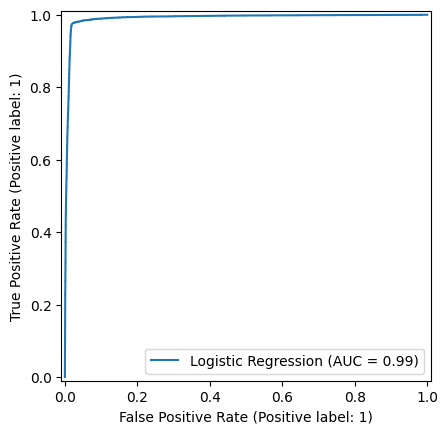

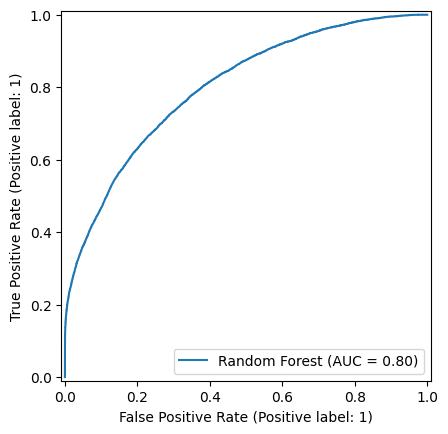

In [ ]:
RocCurveDisplay.from_predictions(y_test, log_pred_prob, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, rf_pred_prob, name="Random Forest")
plt.show()

In [ ]:
print("Logistic Regression")
print(classification_report(y_test, (log_pred_prob > 0.5).astype(int)))

print("\nRandom Forest")
print(classification_report(y_test, (rf_pred_prob > 0.5).astype(int)))

Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     36948
           1       0.94      0.96      0.95     10285

    accuracy                           0.98     47233
   macro avg       0.96      0.97      0.97     47233
weighted avg       0.98      0.98      0.98     47233


Random Forest
              precision    recall  f1-score   support

           0       0.90      0.74      0.81     36948
           1       0.43      0.69      0.53     10285

    accuracy                           0.73     47233
   macro avg       0.66      0.72      0.67     47233
weighted avg       0.79      0.73      0.75     47233



In [ ]:
print("Logistic Regression Confusion Matrix")
print(confusion_matrix(y_test, (log_pred_prob > 0.5).astype(int)))

print("\nRandom Forest Confusion Matrix")
print(confusion_matrix(y_test, (rf_pred_prob > 0.5).astype(int)))

Logistic Regression Confusion Matrix
[[36314   634]
 [  381  9904]]

Random Forest Confusion Matrix
[[27522  9426]
 [ 3202  7083]]


## Feature Importance Analysis

Feature importance from the Random Forest model is analyzed to identify
the most influential variables in predicting credit risk.
This provides insights into key risk drivers from a business perspective.


In [ ]:
rf_feature_names = (
    rf_model.named_steps["preprocess"]
    .get_feature_names_out()
)

importances = rf_model.named_steps["model"].feature_importances_

feature_importance = pd.DataFrame({
    "feature": rf_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance.head(15)

,feature,importance
6,num__dti,0.031877
17,num__total_pymnt_inv,0.029477
3,num__int_rate,0.026060
28,cat__term_ 60 months,0.025034
407778,cat__next_pymnt_d_Jan-16,0.024293
16,num__out_prncp_inv,0.022895
27,cat__term_ 36 months,0.019699
407861,cat__last_credit_pull_d_Nov-15,0.017984
43,cat__sub_grade_B3,0.017549
29,cat__grade_A,0.014648


In [ ]:
print(f"Logistic Regression ROC-AUC: {log_auc:.4f}")
print(f"Random Forest ROC-AUC: {rf_auc:.4f}")

best_model = "Random Forest" if rf_auc > log_auc else "Logistic Regression"
print("Selected Model:", best_model)

Logistic Regression ROC-AUC: 0.9907
Random Forest ROC-AUC: 0.8004
Selected Model: Logistic Regression


## Business Recommendation

Based on the evaluation results, the Random Forest model demonstrates stronger predictive performance
and is recommended as the final model.

The predicted probability of default can be used to:
- Adjust approval thresholds
- Support credit policy decisions
- Balance loan growth and risk exposure